In [20]:
import OpenEXR, Imath
import numpy as np
import matplotlib.pyplot as plt

def read_exr(path):
    exr = OpenEXR.InputFile(path)
    header = exr.header()
    # determine image size
    dw = header['dataWindow']
    w, h = dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1

    # list available channels
    chan_names = list(header['channels'].keys())
    # pick the depth channel: prefer 'Z', else the first one
    depth_chan = 'Z' if 'Z' in chan_names else chan_names[0]
    # set pixel type to float32
    pt = Imath.PixelType(Imath.PixelType.FLOAT)

    # read that channel
    depth_str = exr.channel(depth_chan, pt)
    depth = np.frombuffer(depth_str, dtype=np.float32)
    return depth.reshape(h, w)

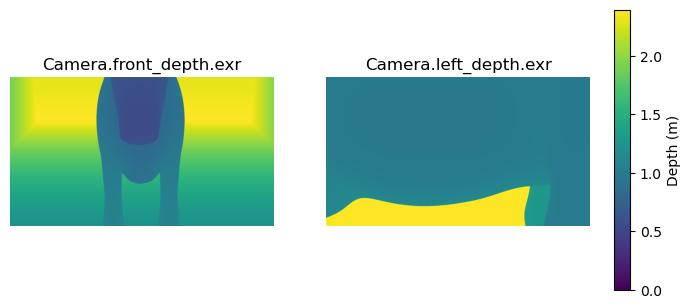

In [21]:
# Paths to your depth EXRs
depth_files = [
    'renders/Camera.front_depth.exr',
    'renders/Camera.left_depth.exr',
]

import matplotlib.pyplot as plt

# 1) make room on the right for the cbar
fig, axes = plt.subplots(1, len(depth_files), 
                         figsize=(4*len(depth_files), 4))
if len(depth_files) == 1:
    axes = [axes]

# 2) plot each depth map
for ax, path in zip(axes, depth_files):
    depth = read_exr(path)
    im = ax.imshow(depth, vmin=0)
    ax.set_title(path.split("/")[-1])
    ax.axis("off")

# 3) carve out space and stick the cbar there
fig.subplots_adjust(right=0.85)                    # leave 15% on the right
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])     # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label="Depth (m)")

plt.show()